# Future Work Figures

In [21]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import NullLocator,MaxNLocator
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.visualization import AsinhStretch,SqrtStretch,ImageNormalize
import sunpy
from sunpy.map import Map
from hydrad_tools.configure import Configure
from hydrad_tools.parse import Strand
from hydrad_tools.visualize import animate_strand,plot_strand

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [2]:
def spatial_heating_profile(s,config_filename):
    conf = Configure.load_config(config_filename)
    h = u.Quantity(np.zeros(s.shape), 'erg / (cm^3*s)')
    for e in conf['heating']['events']:
        h += e['rate'] * np.exp(-((s - e['location'])**2)/(2*((e['scale_height'])**2)))
    return h

In [3]:
i_start,i_stop,i_step = 0,-1,10
with h5py.File('../thesis/chapter8/data/hydrad_tne_results.h5','r') as hf:
    t_grid = u.Quantity(hf['time'][i_start:i_stop:i_step],hf['time'].attrs['unit'])
    s_grid = u.Quantity(hf['coordinate'],hf['coordinate'].attrs['unit'])
    Te_grid = u.Quantity(hf['electron_temperature'][i_start:i_stop:i_step,:],
                         hf['electron_temperature'].attrs['unit'])
    Ti_grid = u.Quantity(hf['ion_temperature'][i_start:i_stop:i_step,:],
                         hf['ion_temperature'].attrs['unit'])
    n_grid = u.Quantity(hf['density'][i_start:i_stop:i_step,:],
                        hf['density'].attrs['unit'])
    v_grid = u.Quantity(hf['velocity'][i_start:i_stop:i_step,:],
                        hf['velocity'].attrs['unit'])

## Heating Profile

In [4]:
h_profile = spatial_heating_profile(s_grid,'../thesis/chapter8/data/hydrad_tne_config.asdf')

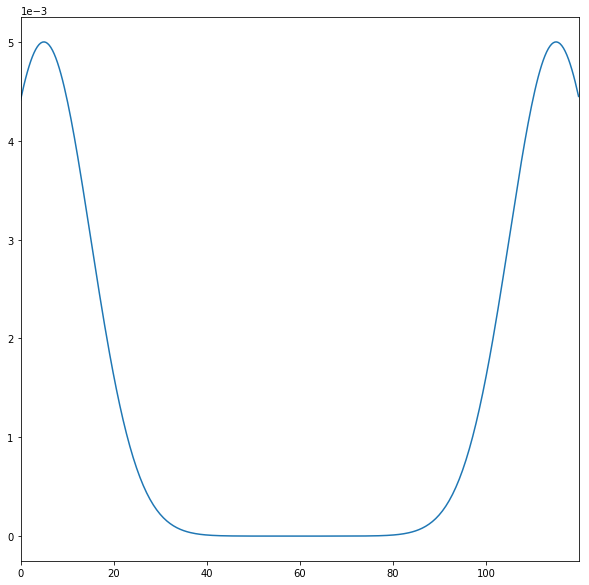

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(s_grid.to(u.Mm), h_profile)
ax.set_xlim(s_grid.to(u.Mm)[[0,-1]].value)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

## $T,n$ Profiles

In [8]:
tmesh,smesh = np.meshgrid(s_grid.to(u.Mm), t_grid.to(u.h))

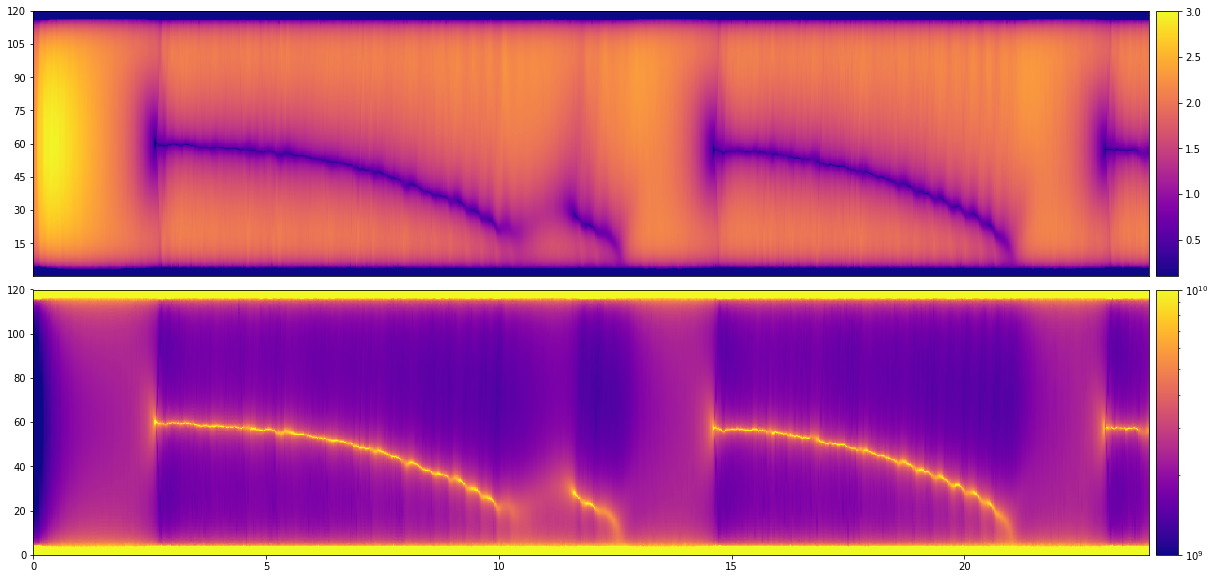

In [36]:
fig,axes = plt.subplots(2,1,figsize=(20,10))
# Temperature
im_T = axes[0].pcolormesh(smesh, tmesh, Te_grid.to(u.MK),
                        cmap='plasma',
                        vmin=0.1,
                        vmax=3,
                        rasterized=True)
# Density
im_n = axes[1].pcolormesh(smesh, tmesh, n_grid,
                          cmap='plasma',
                          norm=matplotlib.colors.LogNorm(vmin=1e9,vmax=1e10),
                          rasterized=True)
# Labels, ticks
axes[0].xaxis.set_major_locator(NullLocator())
axes[0].yaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.subplots_adjust(hspace=0.05)
# Colorbars
pos = axes[0].get_position().get_points()
cax = fig.add_axes([pos[1,0]+0.005,pos[0,1],0.015,pos[1,1]-pos[0,1]])
cbar = fig.colorbar(im_T, cax=cax, orientation='vertical')
pos = axes[1].get_position().get_points()
cax = fig.add_axes([pos[1,0]+0.005,pos[0,1],0.015,pos[1,1]-pos[0,1]])
cbar = fig.colorbar(im_n, cax=cax, orientation='vertical')